<a href="https://colab.research.google.com/github/dbtmddn41/deep_learning/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import TextVectorization


In [ ]:
!pip install konlpy

from konlpy.tag import Okt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 45.1 MB/s eta 0:00:00


In [ ]:
okt = Okt()

okt.morphs("안녕 나는 승우라고 해.")

['안녕', '나', '는', '승우', '라고', '해', '.']

In [ ]:
# class Vectorizer:
#     def __init__(self):
#         self.okt = Okt()
#     def tokenize(self, text):
#         return self.okt.morphs(text)
#     def make_vocabulary(self, dataset):
#         self.vocabulary = {"": 0, "[UNK]": 1}
#         for text in dataset:
#             tokens = self.tokenize(text)
#             for token in tokens:
#                 if token not in self.vocabulary:
#                     self.vocabulary


True


In [ ]:
max_length = 600
max_tokens = 20000

okt = Okt()

def okt_split(str_tensor):
    string = okt.morphs(str_tensor.numpy())
    return tf.constant(string)


text_vectorization = TextVectorization(output_mode="int")

ex_dataset = ["안녕 나는 승우야." , "만나서 반가워", "나도", "이 씨발 형!"]
' '.join(okt.morphs(ex_dataset[0]))

ex_dataset = list(map(lambda x: ' '.join(okt.morphs(x)), ex_dataset))

text_vectorization.adapt(ex_dataset)

vocabs = text_vectorization.get_vocabulary()
print(vocabs)
encoded_sentence = text_vectorization("안녕 , 나 는 조 씨 야 .")
print(encoded_sentence)
inversed_vocabs = dict(enumerate(vocabs))
decoded_sentence = ' '.join([inversed_vocabs[int(word)] for word in encoded_sentence])
print(decoded_sentence)

['', '[UNK]', '형', '이', '우야', '안녕', '씨발', '승', '반가워', '만나서', '는', '나도', '나']
tf.Tensor([ 5 12 10  1  1  1], shape=(6,), dtype=int64)
안녕 나 는 [UNK] [UNK] [UNK]


# 데이터 준비하기

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from tqdm import tqdm

### 원본 데이터 가공

In [ ]:
dataset_names = []

filenames = os.listdir(".")
for filename in filenames:
    name, ext = os.path.splitext(filename)
    if ext == '.xlsx':
        dataset_names.append(name)
dataset_names.sort()
print(list(zip(range(len(dataset_names)), dataset_names)))

#['1_구어체(1)', '1_구어체(2)', '6_문어체_지자체웹사이트', '3_문어체_뉴스(1)_200226', '3_문어체_뉴스(3)', '3_문어체_뉴스(4)', '2_대화체', '4_문어체_한국문화', '3_문어체_뉴스(2)', '5_문어체_조례']

[(0, '1_구어체(1)'), (1, '1_구어체(2)'), (2, '2_대화체'), (3, '3_문어체_뉴스(1)_200226'), (4, '3_문어체_뉴스(2)'), (5, '3_문어체_뉴스(3)'), (6, '3_문어체_뉴스(4)'), (7, '4_문어체_한국문화'), (8, '5_문어체_조례'), (9, '6_문어체_지자체웹사이트'), (10, 'rnn_translate'), (11, 'translate')]


In [ ]:
order = [0, 1, 9,3,5,6,2,7,4,8]
dataset__ = [0 for _ in range(len(order))]
for i in range(len(order)):
    dataset__[i] = dataset_names[order[i]]

dataset_names = dataset__
print(dataset_names)

['1_구어체(1)', '1_구어체(2)', '6_문어체_지자체웹사이트', '3_문어체_뉴스(1)_200226', '3_문어체_뉴스(3)', '3_문어체_뉴스(4)', '2_대화체', '4_문어체_한국문화', '3_문어체_뉴스(2)', '5_문어체_조례']


In [ ]:
train_data = pd.DataFrame({'원문':[], '번역문':[]})
val_data = pd.DataFrame({'원문':[], '번역문':[]})
test_data = pd.DataFrame({'원문':[], '번역문':[]})
for name in tqdm(dataset_names, desc="진행률"):
    datas = pd.read_excel(name+'.xlsx')
    datas = datas[["원문", "번역문"]]
    # train, tmp = train_test_split(datas, train_size=0.1, test_size=0.1, random_state=42, shuffle=True)
    train, tmp = train_test_split(datas, train_size=0.8, random_state=42, shuffle=True)
    # val, test = train_test_split(tmp, train_size=0.5, random_state=42, shuffle=True)
    val, test = train_test_split(tmp, train_size=0.999, random_state=42, shuffle=True)

    train_data = pd.concat([train_data, train], ignore_index=True)
    val_data = pd.concat([val_data, val], ignore_index=True)
    test_data = pd.concat([test_data, test], ignore_index=True)

진행률:  10%|█         | 1/10 [00:14<02:14, 14.91s/it]/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
진행률:  20%|██        | 2/10 [00:29<01:58, 14.80s/it]/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
진행률:  70%|███████   | 7/10 [02:20<01:02, 20.84s/it]/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
진행률:  90%|█████████ | 9/10 [02:59<00:21, 21.16s/it]/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpy

In [ ]:
print(len(train_data), len(val_data), len(test_data))
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

1281931 320161 326


In [ ]:
train_data.tail()

,원문,번역문
1281926,"냉장고, 계산대(뒷공간 포함), 진열장, 현금지급기, 에어컨, 식음대 등의 면적은 ...","The space for the refrigerator, cash register ..."
1281927,제49조의 규정에 따른 관사 중 다음 각 호의 어느 하나에 해당하는 경우에는 사용료...,The full amount of fees may be exempted where ...
1281928,공공기관의 장은 특별한 이유가 없는 한 동일한 노동에 대해서는 무기계약근로자와 기간...,The head of a public agency shall endeavor to ...
1281929,정신보건사업에 관한 사항(노원정신건강복지센터 등 관리 및 운영),Matters concerning mental health services (suc...
1281930,"“수익자부담경비”란 수업료, 입학금 외에 학교운영위원회의 심의를 거쳐 학부모가 부담...","The term ""expenses borne by beneficiaries"" mea..."


In [ ]:
import re
import string

In [ ]:
okt = Okt()
max_len = 0

def okt_mophs(kor_str):
    global max_len
    morphs = okt.morphs(kor_str)
    max_len = max(len(morphs), max_len)
    return ' '.join(morphs)

tqdm.pandas()
train_korean_data = train_data['원문'].progress_apply(okt_mophs)
tqdm.pandas()
val_korean_data = val_data['원문'].progress_apply(okt_mophs)
tqdm.pandas()
test_korean_data = test_data['원문'].progress_apply(okt_mophs)
# korean_morphs = list(parmap.map(okt_mophs, train_data['원문'], pm_pbar=True, pm_processes=num_cores))

def add_token(string):
    return f"[start] {string} [end]"
train_english_data = train_data['번역문'].apply(add_token)
val_english_data = val_data['번역문'].apply(add_token)
# english_morphs = list(parmap.map(add_token, train_data['번역문'], pm_pbar=True, pm_processes=num_cores))


100%|██████████| 326/326 [00:01<00:00, 231.21it/s]


144


KeyboardInterrupt: ignored

In [ ]:
preprocessed_datas = pd.concat([train_korean_data, val_korean_data, test_korean_data, train_english_data, val_english_data], axis=1)
preprocessed_datas.to_csv("preprocessed_datas.csv")

### 이미 가공된 데이터 불러오기

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '딥러닝/keras_creator/Lecture\ 11.'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/딥러닝/keras_creator/Lecture 11.


In [ ]:
# !unzip preprocessed_datas.zip -d .
preprocessed_data = pd.read_csv("preprocessed_datas.csv", index_col=0)

train_korean_data = preprocessed_data['train_korean'].dropna()
val_korean_data = preprocessed_data['val_korean'].dropna()
test_korean_data = preprocessed_data['test_korean'].dropna()
train_english_data = preprocessed_data['train_english'].dropna()
val_english_data = preprocessed_data['val_english'].dropna()

<ipython-input-10-73c036d2bdab>:2: DtypeWarning: Columns (2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  preprocessed_data = pd.read_csv("preprocessed_datas.csv", index_col=0)


In [ ]:
preprocessed_data = pd.concat([train_korean_data, val_korean_data, test_korean_data, train_english_data, val_english_data],
                              axis=1, keys=['train_korean', 'val_korean', 'test_korean', 'train_english', 'val_english'])
preprocessed_data.to_csv("preprocessed_datas.csv")



In [ ]:
preprocessed_data.tail()

,train_korean,val_korean,test_korean,train_english,val_english
1281926.0,"냉장고 , 계산 대 ( 뒷 공간 포함 ), 진열 장 , 현금 지급 기 , 에어컨 ,...",NaN,NaN,"[start] The space for the refrigerator, cash r...",NaN
1281927.0,제 49조 의 규정 에 따른 관사 중 다음 각 호의 어느 하나 에 해당 하는 경우 ...,NaN,NaN,[start] The full amount of fees may be exempte...,NaN
1281928.0,공공기관 의 장 은 특별한 이유 가 없는 한 동일한 노동 에 대해 서는 무기 계 약...,NaN,NaN,[start] The head of a public agency shall ende...,NaN
1281929.0,정신 보건 사업 에 관 한 사항 ( 노원 정신건강 복지 센터 등 관리 및 운영 ),NaN,NaN,[start] Matters concerning mental health servi...,NaN
1281930.0,"“ 수익 자 부담 경비 ” 란 수업료 , 입학 금 외 에 학교 운영 위원회 의 심의...",NaN,NaN,"[start] The term ""expenses borne by beneficiar...",NaN


In [ ]:
!zip -r preprocessed_datas.zip  preprocessed_datas.csv

updating: preprocessed_datas.csv (deflated 59%)


## vectorize 및 tf.data

In [ ]:
import string
import re

In [ ]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace('[', '')
strip_chars = strip_chars.replace(']', '')

def target_standardization(input_string):
    lower_case = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lower_case, f"[{re.escape(strip_chars)}]", '')

vocab_size = 150000
sequence_len = 35
korean_vectorization = layers.TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_len)
english_vectorization = layers.TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_len+1, standardize=target_standardization)

korean_vectorization.adapt(train_korean_data)
english_vectorization.adapt(train_english_data)

In [ ]:
# import pickle
# kor_vocab = korean_vectorization.get_vocabulary()
# eng_vocab = english_vectorization.get_vocabulary()
# print(type(kor_vocab))
# with open('kor_vocab.pkl', 'wb') as f:
# 	pickle.dump(kor_vocab, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('eng_vocab.pkl', 'wb') as f:
# 	pickle.dump(eng_vocab, f, protocol=pickle.HIGHEST_PROTOCOL)

<class 'list'>


In [ ]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace('[', '')
strip_chars = strip_chars.replace(']', '')

def target_standardization(input_string):
    lower_case = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lower_case, f"[{re.escape(strip_chars)}]", '')

vocab_size = 15000
sequence_len = 35

korean_vectorization = layers.TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_len)
english_vectorization = layers.TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_len+1, standardize=target_standardization)

import pickle
with open('kor_vocab.pkl', 'rb') as f:
    kor_vocab = pickle.load(f)
    korean_vectorization.set_vocabulary(kor_vocab)

with open('eng_vocab.pkl', 'rb') as f:
    eng_vocab = pickle.load(f)
    english_vectorization.set_vocabulary(eng_vocab)

In [ ]:
batch_size = 128

def format_dataset(kor, eng):
    kor = korean_vectorization(kor)
    eng = english_vectorization(eng)
    return ({'korean': kor, 'english': eng[:, :-1]}, eng[:, 1:])

def make_dataset(korean, english):
    dataset = tf.data.Dataset.from_tensor_slices((korean, english))

    dataset = dataset.batch(batch_size)

    dataset = dataset.map(format_dataset, num_parallel_calls=16)

    return dataset.prefetch(16).cache()

print(len(train_korean_data), len(train_english_data))

train_korean_data = train_korean_data.sample(frac=1, random_state=1)
train_english_data = train_english_data.sample(frac=1, random_state=1)
val_korean_data = val_korean_data.sample(frac=1, random_state=1)
val_english_data = val_english_data.sample(frac=1, random_state=1)
print(len(train_korean_data), len(train_english_data))

train_dataset = make_dataset(train_korean_data, train_english_data)
val_dataset = make_dataset(val_korean_data, val_english_data)
test_X = korean_vectorization(test_korean_data)


1281932 1281932
1281932 1281932


In [ ]:
for inputs, targets in train_dataset.take(1):
    print(f"korean input shape: {inputs['korean'].shape}")
    print(f"english input shape: {inputs['english'].shape}")
    print(f"targets input shape: {targets.shape}")

print("test set:")
print(f"korean input shape: {test_X.shape}")

korean input shape: (1024, 35)
english input shape: (1024, 35)
targets input shape: (1024, 35)
test set:
korean input shape: (327, 35)


# RNN Seq2Seq

In [ ]:
embed_dim = 256
latent_dim = 1024

src = keras.Input(shape=(sequence_len,), dtype='int64', name="korean")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(src)
encoded_src = layers.Bidirectional(layers.GRU(latent_dim), merge_mode='sum')(x)

encoder = keras.Model(src, encoded_src, name='rnn_encoder')
encoder.summary()

Model: "rnn_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 korean (InputLayer)         [(None, 35)]              0         
                                                                 
 embedding (Embedding)       (None, 35, 256)           3840000   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             7876608   
 l)                                                              
                                                                 
Total params: 11,716,608
Trainable params: 11,716,608
Non-trainable params: 0
_________________________________________________________________


In [ ]:
past_target = keras.Input(shape=(sequence_len,), dtype='int64', name='english')
encoded = keras.Input(shape=(latent_dim,), name='encoded_korean', dtype='float32')
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation='softmax')(x)

decoder = keras.Model([past_target, encoded], target_next_step)
decoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 256)      3840000     ['english[0][0]']                
                                                                                                  
 encoded_korean (InputLayer)    [(None, 1024)]       0           []                               
                                                                                                  
 gru_1 (GRU)                    (None, 35, 1024)     3938304     ['embedding_1[0][0]',            
                                                                  'encoded_korean[0][0]']     

In [ ]:
src = keras.Input(shape=(sequence_len,), dtype='int64', name="korean")
past_target = keras.Input(shape=(sequence_len,), dtype='int64', name='english')

encoded_src = encoder(src)
target_next_step = decoder({'english': past_target, 'encoded_korean': encoded_src})
seq2seq_rnn = keras.Model([src, past_target], target_next_step)
seq2seq_rnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 korean (InputLayer)            [(None, 35)]         0           []                               
                                                                                                  
 rnn_encoder (Functional)       (None, 1024)         11716608    ['korean[0][0]']                 
                                                                                                  
 english (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 model (Functional)             (None, 35, 15000)    23153304    ['rnn_encoder[0][0]',            
                                                                  'english[0][0]']          

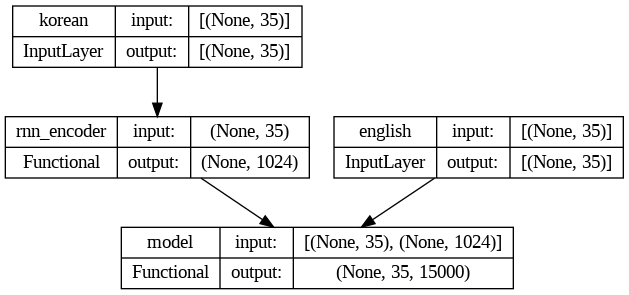

In [ ]:
keras.utils.plot_model(seq2seq_rnn, 'seq2seq_rnn.png', show_shapes=True, show_layer_activations=True)

In [ ]:
seq2seq_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
seq2seq_rnn = keras.models.load_model('seq2seq_rnn.keras')

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('seq2seq_rnn.keras', save_best_only=True),
             keras.callbacks.EarlyStopping(patience=1)]

seq2seq_rnn.fit(train_dataset, validation_data=val_dataset, epochs=30, callbacks=callbacks)

Epoch 1/30
20031/20031 [==============================] - 1190s 59ms/step - loss: 2.5392 - val_loss: 2.8597
Epoch 2/30
20031/20031 [==============================] - 971s 48ms/step - loss: 2.5273 - val_loss: 2.8516
Epoch 3/30
20031/20031 [==============================] - 964s 48ms/step - loss: 2.5173 - val_loss: 2.8446
Epoch 4/30
20031/20031 [==============================] - 966s 48ms/step - loss: 2.5085 - val_loss: 2.8375
Epoch 5/30
  115/20031 [..............................] - ETA: 12:46 - loss: 2.0978

KeyboardInterrupt: ignored

In [ ]:
best_rnn = keras.models.load_model('seq2seq_rnn.keras')

encoder = best_rnn.layers[1]
decoder = best_rnn.layers[3]

In [ ]:
import numpy as np

eng_vocab = english_vectorization.get_vocabulary()
eng_index_lookup = np.pad(np.array(eng_vocab), pad_width=(0,vocab_size), mode='constant', constant_values='[UNK]')[:vocab_size]
max_decoded_sentence_len = sequence_len
def decode_sequence(input_vectors):
    batch_size = input_vectors.shape[0]
    encoded_input_sentence = encoder.predict(input_vectors)
    decoded_sentence = np.repeat(np.array('[start]'), batch_size).reshape(-1, 1)
    blank = np.repeat(np.array(' '), batch_size).reshape(-1, 1)

    tokenized_target_sentence = english_vectorization(decoded_sentence)[:, :-1]
    tokenized_target_sentence = tf.Variable(initial_value=tokenized_target_sentence)

    for i in range(max_decoded_sentence_len):
        next_token_predict = decoder.predict([tokenized_target_sentence, encoded_input_sentence])
        sampled_token_index = tf.random.categorical(next_token_predict[:, i], 1)
        # sampled_token_index = np.argmax(next_token_predict[:, i],axis=1)
        sampled_token = eng_index_lookup[sampled_token_index]
        if i < max_decoded_sentence_len-1:
            tokenized_target_sentence[:, i+1, tf.newaxis].assign(sampled_token_index)
        decoded_sentence = np.char.add(decoded_sentence, np.char.add(blank, sampled_token))
        # if sampled_token == '[end]':
        #     break
    return decoded_sentence

translated_sentence = decode_sequence(test_X)
for i in range(15):
    print(test_data.iloc[i], "- predict: ", translated_sentence[i])

11/11 [==============================] - 0s 7ms/step


NameError: ignored

In [ ]:
for i in range(15):
    print(test_data.iloc[i], "- predict: ", translated_sentence[i])

원문                     돈을 오직 나를 위해서만 써야 해요.
번역문    I should spend the money only on me.
Name: 0, dtype: object - predict:  ['[start] find legislative deeply esther considerations phoenix much injury gist grading restaurant moisturizing accommodate hobbies devil ease expanding but wastes hurriedly vests boat salted spine scarf 203 youngrok confidential brian tiring breath symposium shut populations tying']
원문            그럼 정해진 시간까지 재 답신 부탁드립니다.
번역문    Please reply this back in time.
Name: 1, dtype: object - predict:  ['[start] hardship findings telegraph collectors nurse constructor reporter gochujang outcomes understanding banners checked protocol studios personally cessation diplomats jyp sumi kims exercises dads equation shinee muhammad emotional awarded reporter hallasan identified severance lectures familiarity can signatures']
원문             나중에 헤라클레스가 그를 도와줄 거야.
번역문    Hercules will help him later.
Name: 2, dtype: object - predict:  ['[start] reviews grace competitively unison co

In [ ]:
test_data['rnn 번역결과'] = pd.DataFrame(translated_sentence)
test_data.head()
test_data.to_excel('rnn_translate.xlsx')

#Transformer

In [ ]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=self.dropout_rate)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation='relu'), layers.Dense(embed_dim)])
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(query=inputs, value=inputs, attention_mask=mask)
        x = inputs + self.dropout1(attention_output)
        x = self.layernorm_1(x)
        proj_output = self.dense_proj(x)
        x = self.dropout2(proj_output) + x
        output = self.layernorm_2(x)

        return output

    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim": self.embed_dim, "dense_dim": self.dense_dim, "num_heads": self.num_heads, 'dropout_rate': self.dropout_rate})
        return config

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_len, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)#, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)
        self.position_embeddings = layers.Embedding(input_dim=sequence_len, output_dim=output_dim)
        self.sequence_len = sequence_len
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({"sequence_len": self.sequence_len, "input_dim": self.input_dim, "output_dim": self.output_dim})
        return config

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, num_blocks, sequence_len, vocab_size, embed_dim, dense_dim, num_heads, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.num_blocks = num_blocks
        self.sequence_len = sequence_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        self.pos_embedding = PositionalEmbedding(sequence_len, vocab_size, embed_dim)
        block_layers = []
        for i in range(num_blocks):
            block_layers.append(TransformerEncoderBlock(embed_dim, dense_dim, num_heads, dropout_rate))
        self.block_layers = keras.Sequential(block_layers)

    def call(self, inputs):
        pos_inputs = self.pos_embedding(inputs)
        encoded = self.block_layers(pos_inputs)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_blocks': self.num_blocks, 'sequence_len': self.sequence_len,
            'vocab_size': self.vocab_size, 'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim, 'num_heads': self.num_heads,
            'dropout_rate': self.dropout_rate
        })
        return config

In [ ]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim": self.embed_dim, "dense_dim": self.dense_dim, "num_heads": self.num_heads, 'dropout_rate': self.dropout_rate})
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_len = input_shape[0], input_shape[1]
        i = tf.range(sequence_len)[:, tf.newaxis]
        j = tf.range(sequence_len)
        mask = tf.cast(i >= j, dtype='int32')
        mask = tf.reshape(mask, (1, sequence_len, sequence_len))
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype='int32')
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(query=inputs, key=inputs, value=inputs, attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(self.dropout1(attention_output_1)+inputs)
        attention_output_2 = self.attention_2(query=attention_output_1, key=encoder_outputs, value=encoder_outputs, attention_mask=padding_mask)
        attention_output_2 = self.layernorm_2(self.dropout2(attention_output_2) + attention_output_1)
        proj_output = self.dense_proj(attention_output_2)
        outputs = self.layernorm_3(attention_output_2 + self.dropout3(proj_output))
        return outputs

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, num_blocks, sequence_len, vocab_size, embed_dim, dense_dim, num_heads, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.num_blocks = num_blocks
        self.sequence_len = sequence_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        self.pos_embedding = PositionalEmbedding(sequence_len, vocab_size, embed_dim)
        self.block_layers = []
        for i in range(num_blocks):
            self.block_layers.append(TransformerDecoderBlock(embed_dim, dense_dim, num_heads, dropout_rate))
        self.dropout = layers.Dropout(dropout_rate)
        self.dense = layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, encoder_outputs):
        x = self.pos_embedding(inputs)
        for decoder_block in self.block_layers:
            x = decoder_block(x, encoder_outputs)
        x = self.dropout(x)
        outputs = self.dense(x)
        return outputs

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_blocks': self.num_blocks, 'sequence_len': self.sequence_len,
            'vocab_size': self.vocab_size, 'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim, 'num_heads': self.num_heads,
            'dropout_rate': self.dropout_rate
            })
        return config

In [ ]:
num_blocks = 4
embed_dim = 256
dense_dim = 2048
num_heads = 3


encoder_inputs = keras.Input(shape=(sequence_len), dtype='int32', name='korean')
encoder_outputs = TransformerEncoder(num_blocks, sequence_len, vocab_size, embed_dim, dense_dim, num_heads, 0.1)(encoder_inputs)
transformer_encoder = keras.Model(encoder_inputs, encoder_outputs, name='transformer_encoder')

decoder_inputs = keras.Input(shape=(sequence_len), dtype='int32', name='english')
encoded_inputs = keras.Input(shape=(sequence_len, embed_dim), dtype='float', name='encoded_korean')
decoder_outputs = TransformerDecoder(num_blocks, sequence_len, vocab_size, embed_dim, dense_dim, num_heads, 0.1)(decoder_inputs, encoded_inputs)
transformer_decoder = keras.Model([decoder_inputs, encoded_inputs], decoder_outputs, name='transformer_decoder')
transformer_decoder.summary()

Model: "transformer_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 encoded_korean (InputLayer)    [(None, 35, 256)]    0           []                               
                                                                                                  
 transformer_decoder (Transform  (None, 35, 15000)   18225560    ['english[0][0]',                
 erDecoder)                                                       'encoded_korean[0][0]']         
                                                                                                  
Total params: 18,225,560
Trainable params: 18,225,560
Non-trainable params: 0
__

In [ ]:
encoder_inputs = keras.Input(shape=(sequence_len), dtype='int32', name='korean')
decoder_inputs = keras.Input(shape=(sequence_len), dtype='int32', name='english')
encoded_inputs = transformer_encoder(encoder_inputs)
decoder_outputs = transformer_decoder([decoder_inputs, encoded_inputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name='transformer')

In [ ]:
transformer.summary()
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 korean (InputLayer)            [(None, 35)]         0           []                               
                                                                                                  
 english (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 transformer_encoder (Functiona  (None, 35, 256)     11212544    ['korean[0][0]']                 
 l)                                                                                               
                                                                                                  
 transformer_decoder (Functiona  (None, 35, 15000)   18225560    ['english[0][0]',      

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('seq2seq_transformer2.keras', save_best_only=True),
             keras.callbacks.EarlyStopping(patience=5)]
# keras.mixed_precision.set_global_policy("mixed_float16")
# keras.backend.floatx()
best_transformer.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
   13/10016 [..............................] - ETA: 1:31:17 - loss: 1.7407 - accuracy: 0.6035

KeyboardInterrupt: ignored

In [ ]:
best_transformer = keras.models.load_model('seq2seq_transformer.keras', custom_objects={'TransformerEncoderBlock': TransformerEncoderBlock, 'PositionalEmbedding': PositionalEmbedding,
                                    'TransformerEncoder': TransformerEncoder, 'TransformerDecoderBlock': TransformerDecoderBlock, 'TransformerDecoder': TransformerDecoder})
print(best_transformer.layers)
encoder = best_transformer.layers[2]
decoder = best_transformer.layers[3]
print(encoder.name, decoder.name)

[<keras.engine.input_layer.InputLayer object at 0x7f8f1e853fa0>, <keras.engine.input_layer.InputLayer object at 0x7f8f1e8508e0>, <keras.engine.functional.Functional object at 0x7f8f1e853850>, <keras.engine.functional.Functional object at 0x7f8f1e9eee90>]
transformer_encoder transformer_decoder


In [ ]:
import numpy as np

eng_vocab = english_vectorization.get_vocabulary()
eng_index_lookup = np.pad(np.array(eng_vocab), pad_width=(0,vocab_size), mode='constant', constant_values='[UNK]')[:vocab_size]
max_decoded_sentence_len = sequence_len
def decode_sequence(input_vectors):
    batch_size = input_vectors.shape[0]
    encoded_input_sentence = encoder.predict(input_vectors)
    decoded_sentence = np.repeat(np.array('[start]'), batch_size).reshape(-1, 1)
    blank = np.repeat(np.array(' '), batch_size).reshape(-1, 1)
    print(blank.shape)
    tokenized_target_sentence = english_vectorization(decoded_sentence)[:, :-1]
    tokenized_target_sentence = tf.Variable(initial_value=tokenized_target_sentence)

    for i in range(max_decoded_sentence_len):
        next_token_predict = decoder.predict([tokenized_target_sentence, encoded_input_sentence])
        # sampled_token_index = tf.random.categorical(next_token_predict[:, i], 1)
        sampled_token_index = np.argmax(next_token_predict[:, i],axis=1).reshape(-1, 1)
        sampled_token = eng_index_lookup[sampled_token_index]
        if i < max_decoded_sentence_len-1:
            tokenized_target_sentence[:, i+1, tf.newaxis].assign(sampled_token_index)
        decoded_sentence = np.char.add(decoded_sentence, np.char.add(blank, sampled_token))
        # if sampled_token == '[end]':
        #     break
    return decoded_sentence

translated_sentence = decode_sequence(test_X)
for i in range(10):
    print(test_data.iloc[i], "- predict: ", translated_sentence[i])

11/11 [==============================] - 0s 17ms/step
(327, 1)
11/11 [==============================] - 0s 17ms/step
원문                                               돈을 오직 나를 위해서만 써야 해요.
번역문                              I should spend the money only on me.
transformer 번역결과    [start] sangjo tendencies bio chungcheongnamdo...
Name: 0, dtype: object - predict:  ['[start] it is 0 [end]                               ']
원문                                           그럼 정해진 시간까지 재 답신 부탁드립니다.
번역문                                   Please reply this back in time.
transformer 번역결과    [start] lock impeachment yeongnam basic nhk di...
Name: 1, dtype: object - predict:  ['[start] you have to spend money only for me [end]  [end]  [end]                      ']
원문                                              나중에 헤라클레스가 그를 도와줄 거야.
번역문                                     Hercules will help him later.
transformer 번역결과    [start] pact scored thailand abuses chorus “at...
Name: 2, dtype: object - predict:  [

In [ ]:
df=pd.DataFrame(translated_sentence).iloc[1:]
df=df.reset_index()
df = df[0]

In [ ]:
test_data['transformer 번역결과'] = df# pd.DataFrame(translated_sentence).iloc[1:]
test_data.head()
test_data.to_excel('translate.xlsx')